In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39663")
client

<Client: 'tcp://127.0.0.1:39663' processes=6 threads=24, memory=187.53 GiB>

In [2]:
client.restart()

<Client: 'tcp://127.0.0.1:45315' processes=0 threads=0, memory=0 B>

In [2]:
import numpy as np
import qgutils
import xarray as xr
import zarr
import shutil
import pickle
from sklearn.neural_network import MLPRegressor
from rechunker import rechunk
import dask.array as dsar
import os.path as op
import scipy.sparse as spar
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/bettik/uchidat/qg-ML/'

In [4]:
U     = .1
T     = 5e5    # seconds
tau0  = .0001
dt    = 5e-2
Rd    = 5e4   # Rossby radius (50km)
Re4   = 4e3
# f0 = 8e-5
beta  = .5
N     = 1024   # Number of horizontal grids
L0    = 80
H     = 5e3
dx    = L0/N  # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny  = 360
Rom   = .025
Ekb   = .002*2
ntime = int(62.2*5)+1

percent = 20
nmemb = 100

ncoars = 4
DX = dx * ncoars

In [5]:
iZ = 0
ntrain = 2
ntime = int(ntrain*63)

dsb = xr.open_dataset(op.join(ddir,"Mean-n04_001.nc")
                     ).isel(time=slice(-ntime,None),Z=iZ).chunk({'time':9,'YC':128,'XC':128})
dsb = xr.concat([dsb,xr.open_dataset(op.join(ddir,"Mean-n04_002.nc")
                                    ).isel(Z=iZ).chunk({'time':9,'YC':128,'XC':128})
                ], 'time')
dsp = xr.open_dataset(op.join(ddir,"Eddy-n04_001.nc")
                     ).isel(time=slice(-ntime,None),Z=iZ).chunk({'time':9,'YC':128,'XC':128})
dsp = xr.concat([dsp,xr.open_dataset(op.join(ddir,"Eddy-n04_002.nc")
                                    ).isel(Z=iZ).chunk({'time':9,'YC':128,'XC':128})
                ], 'time')
dsb

<xarray.Dataset>
Dimensions:  (XC: 258, YC: 258, time: 438)
Coordinates:
  * time     (time) float64 497.0 498.0 499.0 500.0 ... 930.0 931.0 932.0 933.0
    Z        float64 0.03
  * YC       (YC) float64 -0.1562 0.1562 0.4688 0.7812 ... 79.53 79.84 80.16
  * XC       (XC) float64 -0.1562 0.1562 0.4688 0.7812 ... 79.53 79.84 80.16
Data variables:
    qb       (time, YC, XC) float32 dask.array<chunksize=(9, 128, 128), meta=np.ndarray>
    P0b      (time, YC, XC) float32 dask.array<chunksize=(9, 128, 128), meta=np.ndarray>
    P1b      (time, YC, XC) float32 dask.array<chunksize=(9, 128, 128), meta=np.ndarray>
    P2b      (time, YC, XC) float32 dask.array<chunksize=(9, 128, 128), meta=np.ndarray>
    P3b      (time, YC, XC) float32 dask.array<chunksize=(9, 128, 128), meta=np.ndarray>

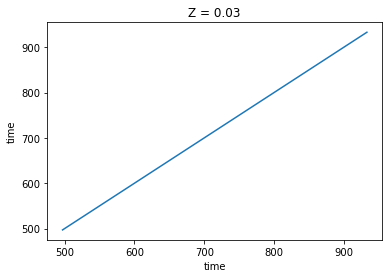

In [6]:
dsb.time.plot()

In [6]:
nGMM = 15
# ver = 1
dsc = xr.open_zarr(op.join(ddir,'EddyPTRCluster/GMM%02d/%03d/Z%02d/' % (nGMM,1,iZ)))
dsc = xr.concat([dsc,xr.open_zarr(op.join(ddir,'EddyPTRCluster/GMM%02d/%03d/Z%02d/' 
                                          % (nGMM,2,iZ)))
                ], 'time'
               ).load()
dsc

<xarray.Dataset>
Dimensions:  (XC: 256, YC: 256, time: 438)
Coordinates:
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * time     (time) float64 497.0 498.0 499.0 500.0 ... 930.0 931.0 932.0 933.0
Data variables:
    cluster  (time, YC, XC) int64 3 5 7 7 7 7 7 7 7 ... 10 10 10 10 10 10 10 10

In [7]:
def pad_bc(psi, bc='dirichlet'):
    """
    Pad field psi with Dirichlet or Neumann boundary conditions
    Parameters
    ----------
    psi : array [nt,nz (,ny,nx)]
    bc   : 'dirichlet' or 'neumann'
    Returns
    -------
    psi_bc: array [nt,nz (,ny+2,nx+2)]
    """
    nd = psi.ndim
    # only pad horizontal dimensions
    if nd == 2:
        psi = np.pad(psi,((1,1),(1,1)),'constant')
    elif nd == 3:
        psi = qgutils.pad_bc(psi)
    elif nd == 4:
        psi = np.pad(psi,((0,0),(0,0),(1,1),(1,1)),'constant')
    elif nd == 5:
        psi = np.pad(psi,((0,0),(0,0),(0,0),(1,1),(1,1)),'constant')

    if (bc == 'dirichlet'): 
        psi[...,0,:]  = -psi[...,1,:]
        psi[...,-1,:] = -psi[...,-2,:]
        psi[...,:,0]  = -psi[...,:,1]
        psi[...,:,-1] = -psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = -psi[...,0,1]   - psi[...,1,0]   - psi[...,1,1]
        psi[...,-1,0]  = -psi[...,-1,1]  - psi[...,-2,0]  - psi[...,-2,1]
        psi[...,0,-1]  = -psi[...,1,-1]  - psi[...,0,-2]  - psi[...,1,-2]
        psi[...,-1,-1] = -psi[...,-1,-2] - psi[...,-2,-2] - psi[...,-2,-1]

    elif (bc == 'neumann'): 
        psi[...,0,:]  = psi[...,1,:]
        psi[...,-1,:] = psi[...,-2,:]
        psi[...,:,0]  = psi[...,:,1]
        psi[...,:,-1] = psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = psi[...,1,1]
        psi[...,-1,0]  = psi[...,-2,1]
        psi[...,0,-1]  = psi[...,1,-2]
        psi[...,-1,-1] = psi[...,-2,-2]

    return psi

In [13]:
# P0 = pad_bc(dsb.P0b)    
# P0x = np.diff(P0[...,1:-1,:], axis=-1) / DX
# P0x = xr.DataArray(.5*(P0x[...,1:] + P0x[...,:-1]), dims=dsb.P0b.dims, coords=dsb.P0b.coords
#                   )
# P0y = np.diff(P0[...,1:-1], axis=-2) / DX
# P0y = xr.DataArray(.5*(P0y[...,1:,:] + P0y[...,:-1,:]), dims=dsb.P0b.dims, coords=dsb.P0b.coords
#                   )

# P1 = pad_bc(dsb.P1b)    
# P1x = np.diff(P1[...,1:-1,:], axis=-1) / DX
# P1x = xr.DataArray(.5*(P1x[...,1:] + P1x[...,:-1]), dims=dsb.P1b.dims, coords=dsb.P1b.coords
#                   )
# P1y = np.diff(P1[...,1:-1], axis=-2) / DX
# P1y = xr.DataArray(.5*(P1y[...,1:,:] + P1y[...,:-1,:]), dims=dsb.P1b.dims, coords=dsb.P1b.coords
#                   )

# P2 = pad_bc(dsb.P2b)    
# P2x = np.diff(P2[...,1:-1,:], axis=-1) / DX
# P2x = xr.DataArray(.5*(P2x[...,1:] + P2x[...,:-1]), dims=dsb.P2b.dims, coords=dsb.P2b.coords
#                   )
# P2y = np.diff(P2[...,1:-1], axis=-2) / DX
# P2y = xr.DataArray(.5*(P2y[...,1:,:] + P2y[...,:-1,:]), dims=dsb.P2b.dims, coords=dsb.P2b.coords
#                   )

# P3 = pad_bc(dsb.P3b)    
# P3x = np.diff(P3[...,1:-1,:], axis=-1) / DX
# P3x = xr.DataArray(.5*(P3x[...,1:] + P3x[...,:-1]), dims=dsb.P3b.dims, coords=dsb.P3b.coords
#                   )
# P3y = np.diff(P3[...,1:-1], axis=-2) / DX
# P3y = xr.DataArray(.5*(P3y[...,1:,:] + P3y[...,:-1,:]), dims=dsb.P3b.dims, coords=dsb.P3b.coords
#                   )
grad2 = xr.open_zarr(op.join(ddir,'mPTRgrad2.zarr')).isel(time=slice(-len(dsb.time.data),None))
P0xx = grad2.P0xx.load()
P0yy = grad2.P0yy.load()

P1xx = grad2.P1xx.load()
P1yy = grad2.P1yy.load()

P2xx = grad2.P2xx.load()
P2yy = grad2.P2yy.load()

P3xx = grad2.P3xx.load()
P3yy = grad2.P3yy.load()
P0xx

<xarray.DataArray 'P0xx' (time: 438, YC: 258, XC: 258)>
array([[[ 2.30992832e+01, -1.16503878e+01,  3.45739722e-02, ...,
          1.32580567e-02,  1.99045353e+01, -3.97754974e+01],
        [-2.30992832e+01,  1.16503878e+01, -3.45739722e-02, ...,
         -1.32580567e-02, -1.99045353e+01,  3.97754974e+01],
        [-2.30917797e+01,  1.16186638e+01, -2.99249291e-02, ...,
         -1.32092293e-02, -1.99054585e+01,  3.97774506e+01],
        ...,
        [-1.61721306e+01,  8.06141281e+00, -4.58316021e-02, ...,
         -1.31677240e-02, -1.99114666e+01,  3.97895584e+01],
        [-1.60858250e+01,  8.09549713e+00, -2.78204344e-02, ...,
         -1.32122785e-02, -1.99106312e+01,  3.97877846e+01],
        [ 1.60858250e+01, -8.09549713e+00,  2.78204344e-02, ...,
          1.32122785e-02,  1.99106312e+01, -3.97877846e+01]],

       [[ 2.29722366e+01, -1.15754251e+01,  4.42199707e-02, ...,
          1.32562248e-02,  1.99045906e+01, -3.97756195e+01],
        [-2.29722366e+01,  1.15754251e+01, -4.42199707e-02, ...,
         -1.32562248e-02, -1.99045906e+01,  3.97756195e+01],
        [-2.29525795e+01,  1.15410395e+01, -4.20190394e-02, ...,
         -1.32110594e-02, -1.99055138e+01,  3.97775726e+01],
...
         -1.31787118e-02, -1.99092560e+01,  3.97851067e+01],
        [-2.13328648e+01,  1.07372227e+01,  8.35143961e-03, ...,
         -1.32269291e-02, -1.99083900e+01,  3.97832718e+01],
        [ 2.13328648e+01, -1.07372227e+01, -8.35143961e-03, ...,
          1.32269291e-02,  1.99083900e+01, -3.97832718e+01]],

       [[ 1.99838524e+01, -1.00455256e+01,  2.87994137e-03, ...,
          1.32238772e-02,  1.99084892e+01, -3.97834854e+01],
        [-1.99838524e+01,  1.00455256e+01, -2.87994137e-03, ...,
         -1.32238772e-02, -1.99084892e+01,  3.97834854e+01],
        [-2.00245686e+01,  9.99492359e+00, -6.92993263e-03, ...,
         -1.31781008e-02, -1.99093571e+01,  3.97853203e+01],
        ...,
        [-2.12997627e+01,  1.06791801e+01, -2.78210435e-02, ...,
         -1.31829847e-02, -1.99092541e+01,  3.97851028e+01],
        [-2.12517910e+01,  1.07202072e+01, -1.62866227e-02, ...,
         -1.32293701e-02, -1.99083881e+01,  3.97832603e+01],
        [ 2.12517910e+01, -1.07202072e+01,  1.62866227e-02, ...,
          1.32293701e-02,  1.99083881e+01, -3.97832603e+01]]],
      dtype=float32)
Coordinates:
  * XC       (XC) float64 -0.1562 0.1562 0.4688 0.7812 ... 79.53 79.84 80.16
  * YC       (YC) float64 -0.1562 0.1562 0.4688 0.7812 ... 79.53 79.84 80.16
    Z        float64 0.03
  * time     (time) float64 497.0 498.0 499.0 500.0 ... 930.0 931.0 932.0 933.0

In [9]:
# clusters = np.concatenate((np.arange(5),np.arange(6,9)))
clusters = range(15)
Ppamp = xr.DataArray(np.zeros((4,nGMM)), dims=['tracer','cluster'],
                     coords={'tracer':range(4),'cluster':clusters}
                    )
gradPbm = xr.DataArray(np.zeros((4,nGMM,2)), dims=['tracer','cluster','orient'],
                       coords={'tracer':range(4),'cluster':clusters,
                               'orient':range(2)}
                      )
UpPpm = xr.DataArray(np.zeros((4,nGMM,2)), dims=['tracer','cluster','orient'],
                     coords={'tracer':range(4),'cluster':clusters,
                             'orient':range(2)}
                    )


for l in clusters:

    Ppamp.sel(cluster=l)[0] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp.upP0p**2 + dsp.vpP0p**2
                                         ).where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                     )).compressed())
    Ppamp.sel(cluster=l)[1] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp.upP1p**2 + dsp.vpP1p**2
                                         ).where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                     )).compressed())
    Ppamp.sel(cluster=l)[2] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp.upP2p**2 + dsp.vpP2p**2
                                         ).where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                     )).compressed())
    Ppamp.sel(cluster=l)[3] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp.upP3p**2 + dsp.vpP3p**2
                                         ).where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                     )).compressed())

    gradPbm.sel(cluster=l)[0,0] = np.nanmedian(np.ma.masked_invalid(P0yy.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                    )).compressed())
    gradPbm.sel(cluster=l)[0,1] = np.nanmedian(np.ma.masked_invalid(P0xx.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                    )).compressed())
    gradPbm.sel(cluster=l)[1,0] = np.nanmedian(np.ma.masked_invalid(P1yy.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                    )).compressed())
    gradPbm.sel(cluster=l)[1,1] = np.nanmedian(np.ma.masked_invalid(P1xx.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                    )).compressed())
    gradPbm.sel(cluster=l)[2,0] = np.nanmedian(np.ma.masked_invalid(P2yy.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                    )).compressed())
    gradPbm.sel(cluster=l)[2,1] = np.nanmedian(np.ma.masked_invalid(P2xx.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                    )).compressed())
    gradPbm.sel(cluster=l)[3,0] = np.nanmedian(np.ma.masked_invalid(P3yy.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                    )).compressed())
    gradPbm.sel(cluster=l)[3,1] = np.nanmedian(np.ma.masked_invalid(P3xx.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                    )).compressed())

    UpPpm.sel(cluster=l)[0,0] = np.nanmedian(np.ma.masked_invalid(dsp.vpP0p.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                         )).compressed())
    UpPpm.sel(cluster=l)[0,1] = np.nanmedian(np.ma.masked_invalid(dsp.upP0p.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                         )).compressed())
    UpPpm.sel(cluster=l)[1,0] = np.nanmedian(np.ma.masked_invalid(dsp.vpP1p.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                         )).compressed())
    UpPpm.sel(cluster=l)[1,1] = np.nanmedian(np.ma.masked_invalid(dsp.upP1p.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                         )).compressed())
    UpPpm.sel(cluster=l)[2,0] = np.nanmedian(np.ma.masked_invalid(dsp.vpP2p.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                         )).compressed())
    UpPpm.sel(cluster=l)[2,1] = np.nanmedian(np.ma.masked_invalid(dsp.upP2p.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                         )).compressed())
    UpPpm.sel(cluster=l)[3,0] = np.nanmedian(np.ma.masked_invalid(dsp.vpP3p.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                         )).compressed())
    UpPpm.sel(cluster=l)[3,1] = np.nanmedian(np.ma.masked_invalid(dsp.upP3p.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                         )).compressed())

In [11]:
for l in clusters[10:]:
    
    p0x_norm = np.ma.masked_invalid(((P0x.where(dsc.cluster==l) 
                                      - gradPbm.sel(tracer=0,orient=1,cluster=l)
                                     ) * Ppamp.sel(tracer=0,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()

    p0y_norm = np.ma.masked_invalid(((P0y.where(dsc.cluster==l) 
                                      - gradPbm.sel(tracer=0,orient=0,cluster=l)
                                     ) * Ppamp.sel(tracer=0,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    
    
    p1x_norm = np.ma.masked_invalid(((P1x.where(dsc.cluster==l) 
                                      - gradPbm.sel(tracer=1,orient=1,cluster=l)
                                     ) * Ppamp.sel(tracer=1,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    p1y_norm = np.ma.masked_invalid(((P1y.where(dsc.cluster==l) 
                                      - gradPbm.sel(tracer=1,orient=0,cluster=l)
                                     ) * Ppamp.sel(tracer=1,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    
    
    p2x_norm = np.ma.masked_invalid(((P2x.where(dsc.cluster==l) 
                                      - gradPbm.sel(tracer=2,orient=1,cluster=l)
                                     ) * Ppamp.sel(tracer=2,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    p2y_norm = np.ma.masked_invalid(((P2y.where(dsc.cluster==l) 
                                      - gradPbm.sel(tracer=2,orient=0,cluster=l)
                                     ) * Ppamp.sel(tracer=2,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    
    
    p3x_norm = np.ma.masked_invalid(((P3x.where(dsc.cluster==l) 
                                      - gradPbm.sel(tracer=3,orient=1,cluster=l)
                                     ) * Ppamp.sel(tracer=3,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    p3y_norm = np.ma.masked_invalid(((P3y.where(dsc.cluster==l) 
                                      - gradPbm.sel(tracer=3,orient=0,cluster=l)
                                     ) * Ppamp.sel(tracer=3,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    
#     nflat = len(np.ma.masked_invalid(dsc.cluster.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))).data).compressed())
    X = p0y_norm[:,np.newaxis]
    X = np.concatenate((X,p0x_norm[:,np.newaxis]),axis=1)
    X = np.concatenate((X,np.concatenate((p1y_norm[:,np.newaxis],p1x_norm[:,np.newaxis]),axis=1)),axis=0)
    X = np.concatenate((X,np.concatenate((p2y_norm[:,np.newaxis],p2x_norm[:,np.newaxis]),axis=1)),axis=0)
    X = np.concatenate((X,np.concatenate((p3y_norm[:,np.newaxis],p3x_norm[:,np.newaxis]),axis=1)),axis=0)
    
    up0_norm = np.ma.masked_invalid(((dsp.upP0p.where(dsc.cluster==l) 
                                      - UpPpm.sel(tracer=0,orient=1,cluster=l)
                                     ) * Ppamp.sel(tracer=0,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    vp0_norm = np.ma.masked_invalid(((dsp.vpP0p.where(dsc.cluster==l) 
                                      - UpPpm.sel(tracer=0,orient=0,cluster=l)
                                     ) * Ppamp.sel(tracer=0,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    
    
    up1_norm = np.ma.masked_invalid(((dsp.upP1p.where(dsc.cluster==l) 
                                      - UpPpm.sel(tracer=1,orient=1,cluster=l)
                                     ) * Ppamp.sel(tracer=1,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    vp1_norm = np.ma.masked_invalid(((dsp.vpP1p.where(dsc.cluster==l) 
                                      - UpPpm.sel(tracer=1,orient=0,cluster=l)
                                     ) * Ppamp.sel(tracer=1,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                    ).compressed()
    
    
    up2_norm = np.ma.masked_invalid(((dsp.upP2p.where(dsc.cluster==l) 
                                      - UpPpm.sel(tracer=2,orient=1,cluster=l)
                                     ) * Ppamp.sel(tracer=2,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    vp2_norm = np.ma.masked_invalid(((dsp.vpP2p.where(dsc.cluster==l) 
                                      - UpPpm.sel(tracer=2,orient=0,cluster=l)
                                     ) * Ppamp.sel(tracer=2,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    
    
    up3_norm = np.ma.masked_invalid(((dsp.upP3p.where(dsc.cluster==l) 
                                      - UpPpm.sel(tracer=3,orient=1,cluster=l)
                                     ) * Ppamp.sel(tracer=3,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    vp3_norm = np.ma.masked_invalid(((dsp.vpP3p.where(dsc.cluster==l) 
                                      - UpPpm.sel(tracer=3,orient=0,cluster=l)
                                     ) * Ppamp.sel(tracer=3,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    
    Y = vp0_norm[:,np.newaxis]
    Y = np.concatenate((Y,up0_norm[:,np.newaxis]),axis=1)
    Y = np.concatenate((Y,np.concatenate((vp1_norm[:,np.newaxis],up1_norm[:,np.newaxis]),axis=1)),axis=0)
    Y = np.concatenate((Y,np.concatenate((vp2_norm[:,np.newaxis],up2_norm[:,np.newaxis]),axis=1)),axis=0)
    Y = np.concatenate((Y,np.concatenate((vp3_norm[:,np.newaxis],up3_norm[:,np.newaxis]),axis=1)),axis=0)

    
    layers = (64, 128, 256, 128, 64, 1)
    mlpr = MLPRegressor(hidden_layer_sizes=layers, max_iter=300).fit(-X,Y)
    filename = ddir+'MLPRegressors/MLPr-%02dlayers_cluster%02d-%02d_6yrs.joblib' % (6,l,nGMM)
#     pickle.dump(mlpr, open(filename, 'wb'))
    from joblib import dump
    dump(mlpr, filename)
    print(filename)

/bettik/uchidat/qg-ML/MLPRegressors/MLPr-06layers_cluster10-15_6yrs.joblib
/bettik/uchidat/qg-ML/MLPRegressors/MLPr-06layers_cluster11-15_6yrs.joblib
/bettik/uchidat/qg-ML/MLPRegressors/MLPr-06layers_cluster12-15_6yrs.joblib
/bettik/uchidat/qg-ML/MLPRegressors/MLPr-06layers_cluster13-15_6yrs.joblib
/bettik/uchidat/qg-ML/MLPRegressors/MLPr-06layers_cluster14-15_6yrs.joblib


In [10]:
for l in clusters[10:]:
    
    p0xx_norm = np.ma.masked_invalid(((P0xx.where(dsc.cluster==l) 
                                      - gradPbm.sel(tracer=0,orient=1,cluster=l)
                                     ) * Ppamp.sel(tracer=0,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()

    p0yy_norm = np.ma.masked_invalid(((P0yy.where(dsc.cluster==l) 
                                      - gradPbm.sel(tracer=0,orient=0,cluster=l)
                                     ) * Ppamp.sel(tracer=0,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    
    
    p1xx_norm = np.ma.masked_invalid(((P1xx.where(dsc.cluster==l) 
                                      - gradPbm.sel(tracer=1,orient=1,cluster=l)
                                     ) * Ppamp.sel(tracer=1,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    p1yy_norm = np.ma.masked_invalid(((P1yy.where(dsc.cluster==l) 
                                      - gradPbm.sel(tracer=1,orient=0,cluster=l)
                                     ) * Ppamp.sel(tracer=1,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    
    
    p2xx_norm = np.ma.masked_invalid(((P2xx.where(dsc.cluster==l) 
                                      - gradPbm.sel(tracer=2,orient=1,cluster=l)
                                     ) * Ppamp.sel(tracer=2,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    p2yy_norm = np.ma.masked_invalid(((P2yy.where(dsc.cluster==l) 
                                      - gradPbm.sel(tracer=2,orient=0,cluster=l)
                                     ) * Ppamp.sel(tracer=2,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    
    
    p3xx_norm = np.ma.masked_invalid(((P3xx.where(dsc.cluster==l) 
                                      - gradPbm.sel(tracer=3,orient=1,cluster=l)
                                     ) * Ppamp.sel(tracer=3,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    p3yy_norm = np.ma.masked_invalid(((P3yy.where(dsc.cluster==l) 
                                      - gradPbm.sel(tracer=3,orient=0,cluster=l)
                                     ) * Ppamp.sel(tracer=3,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    
#     nflat = len(np.ma.masked_invalid(dsc.cluster.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))).data).compressed())
    X = p0yy_norm[:,np.newaxis]
    X = np.concatenate((X,p0xx_norm[:,np.newaxis]),axis=1)
    X = np.concatenate((X,np.concatenate((p1yy_norm[:,np.newaxis],p1xx_norm[:,np.newaxis]),axis=1)),axis=0)
    X = np.concatenate((X,np.concatenate((p2yy_norm[:,np.newaxis],p2xx_norm[:,np.newaxis]),axis=1)),axis=0)
    X = np.concatenate((X,np.concatenate((p3yy_norm[:,np.newaxis],p3xx_norm[:,np.newaxis]),axis=1)),axis=0)
    
    up0_norm = np.ma.masked_invalid(((dsp.upP0p.where(dsc.cluster==l) 
                                      - UpPpm.sel(tracer=0,orient=1,cluster=l)
                                     ) * Ppamp.sel(tracer=0,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    vp0_norm = np.ma.masked_invalid(((dsp.vpP0p.where(dsc.cluster==l) 
                                      - UpPpm.sel(tracer=0,orient=0,cluster=l)
                                     ) * Ppamp.sel(tracer=0,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    
    
    up1_norm = np.ma.masked_invalid(((dsp.upP1p.where(dsc.cluster==l) 
                                      - UpPpm.sel(tracer=1,orient=1,cluster=l)
                                     ) * Ppamp.sel(tracer=1,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    vp1_norm = np.ma.masked_invalid(((dsp.vpP1p.where(dsc.cluster==l) 
                                      - UpPpm.sel(tracer=1,orient=0,cluster=l)
                                     ) * Ppamp.sel(tracer=1,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                    ).compressed()
    
    
    up2_norm = np.ma.masked_invalid(((dsp.upP2p.where(dsc.cluster==l) 
                                      - UpPpm.sel(tracer=2,orient=1,cluster=l)
                                     ) * Ppamp.sel(tracer=2,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    vp2_norm = np.ma.masked_invalid(((dsp.vpP2p.where(dsc.cluster==l) 
                                      - UpPpm.sel(tracer=2,orient=0,cluster=l)
                                     ) * Ppamp.sel(tracer=2,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    
    
    up3_norm = np.ma.masked_invalid(((dsp.upP3p.where(dsc.cluster==l) 
                                      - UpPpm.sel(tracer=3,orient=1,cluster=l)
                                     ) * Ppamp.sel(tracer=3,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    vp3_norm = np.ma.masked_invalid(((dsp.vpP3p.where(dsc.cluster==l) 
                                      - UpPpm.sel(tracer=3,orient=0,cluster=l)
                                     ) * Ppamp.sel(tracer=3,cluster=l)**-1
                                    ).isel(time=slice(None,-int(ntime/2)))
                                   ).compressed()
    
    Y = vp0_norm[:,np.newaxis]
    Y = np.concatenate((Y,up0_norm[:,np.newaxis]),axis=1)
    Y = np.concatenate((Y,np.concatenate((vp1_norm[:,np.newaxis],up1_norm[:,np.newaxis]),axis=1)),axis=0)
    Y = np.concatenate((Y,np.concatenate((vp2_norm[:,np.newaxis],up2_norm[:,np.newaxis]),axis=1)),axis=0)
    Y = np.concatenate((Y,np.concatenate((vp3_norm[:,np.newaxis],up3_norm[:,np.newaxis]),axis=1)),axis=0)

    
    layers = (32, 64, 128, 64, 32, 1)
    mlpr = MLPRegressor(hidden_layer_sizes=layers, max_iter=300).fit(-X,Y)
    filename = ddir+'MLPRegressors/MLPr-%02dlayers_cluster%02d-%02d_grad2-6yrs.joblib' % (6,l,nGMM)
#     pickle.dump(mlpr, open(filename, 'wb'))
    from joblib import dump
    dump(mlpr, filename)
    print(filename)

/bettik/uchidat/qg-ML/MLPRegressors/MLPr-06layers_cluster10-15_grad2-6yrs.joblib
/bettik/uchidat/qg-ML/MLPRegressors/MLPr-06layers_cluster11-15_grad2-6yrs.joblib
/bettik/uchidat/qg-ML/MLPRegressors/MLPr-06layers_cluster12-15_grad2-6yrs.joblib
/bettik/uchidat/qg-ML/MLPRegressors/MLPr-06layers_cluster13-15_grad2-6yrs.joblib
/bettik/uchidat/qg-ML/MLPRegressors/MLPr-06layers_cluster14-15_grad2-6yrs.joblib


In [12]:
# clusters = np.concatenate((np.arange(5),np.arange(6,9)))
clusters = range(nGMM)
Ppamp1 = xr.DataArray(np.zeros((4,nGMM)), dims=['tracer','cluster'],
                     coords={'tracer':range(4),'cluster':clusters}
                    )
gradPbm1 = xr.DataArray(np.zeros((4,nGMM,2)), dims=['tracer','cluster','orient'],
                       coords={'tracer':range(4),'cluster':clusters,
                               'orient':range(2)}
                      )
UpPpm1 = xr.DataArray(np.zeros((4,nGMM,2)), dims=['tracer','cluster','orient'],
                     coords={'tracer':range(4),'cluster':clusters,
                             'orient':range(2)}
                    )


for l in clusters:

    Ppamp1.sel(cluster=l)[0] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp.upP0p**2 + dsp.vpP0p**2
                                         ).where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                     )).compressed())
    Ppamp1.sel(cluster=l)[1] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp.upP1p**2 + dsp.vpP1p**2
                                         ).where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                     )).compressed())
    Ppamp1.sel(cluster=l)[2] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp.upP2p**2 + dsp.vpP2p**2
                                         ).where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                     )).compressed())
    Ppamp1.sel(cluster=l)[3] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp.upP3p**2 + dsp.vpP3p**2
                                         ).where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                     )).compressed())

    gradPbm1.sel(cluster=l)[0,0] = np.nanmedian(np.ma.masked_invalid(P0y.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                    )).compressed())
    gradPbm1.sel(cluster=l)[0,1] = np.nanmedian(np.ma.masked_invalid(P0x.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                    )).compressed())
    gradPbm1.sel(cluster=l)[1,0] = np.nanmedian(np.ma.masked_invalid(P1y.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                    )).compressed())
    gradPbm1.sel(cluster=l)[1,1] = np.nanmedian(np.ma.masked_invalid(P1x.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                    )).compressed())
    gradPbm1.sel(cluster=l)[2,0] = np.nanmedian(np.ma.masked_invalid(P2y.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                    )).compressed())
    gradPbm1.sel(cluster=l)[2,1] = np.nanmedian(np.ma.masked_invalid(P2x.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                    )).compressed())
    gradPbm1.sel(cluster=l)[3,0] = np.nanmedian(np.ma.masked_invalid(P3y.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                    )).compressed())
    gradPbm1.sel(cluster=l)[3,1] = np.nanmedian(np.ma.masked_invalid(P3x.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                    )).compressed())

    UpPpm1.sel(cluster=l)[0,0] = np.nanmedian(np.ma.masked_invalid(dsp.vpP0p.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                         )).compressed())
    UpPpm1.sel(cluster=l)[0,1] = np.nanmedian(np.ma.masked_invalid(dsp.upP0p.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                         )).compressed())
    UpPpm1.sel(cluster=l)[1,0] = np.nanmedian(np.ma.masked_invalid(dsp.vpP1p.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                         )).compressed())
    UpPpm1.sel(cluster=l)[1,1] = np.nanmedian(np.ma.masked_invalid(dsp.upP1p.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                         )).compressed())
    UpPpm1.sel(cluster=l)[2,0] = np.nanmedian(np.ma.masked_invalid(dsp.vpP2p.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                         )).compressed())
    UpPpm1.sel(cluster=l)[2,1] = np.nanmedian(np.ma.masked_invalid(dsp.upP2p.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                         )).compressed())
    UpPpm1.sel(cluster=l)[3,0] = np.nanmedian(np.ma.masked_invalid(dsp.vpP3p.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                         )).compressed())
    UpPpm1.sel(cluster=l)[3,1] = np.nanmedian(np.ma.masked_invalid(dsp.upP3p.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                         )).compressed())

In [10]:
# clusters = np.concatenate((np.arange(5),np.arange(6,9)))
clusters = range(15)
Ppamp1 = xr.DataArray(np.zeros((4,nGMM)), dims=['tracer','cluster'],
                     coords={'tracer':range(4),'cluster':clusters}
                    )
gradPbm1 = xr.DataArray(np.zeros((4,nGMM,2)), dims=['tracer','cluster','orient'],
                       coords={'tracer':range(4),'cluster':clusters,
                               'orient':range(2)}
                      )
UpPpm1 = xr.DataArray(np.zeros((4,nGMM,2)), dims=['tracer','cluster','orient'],
                     coords={'tracer':range(4),'cluster':clusters,
                             'orient':range(2)}
                    )


for l in clusters:

    Ppamp1.sel(cluster=l)[0] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp.upP0p**2 + dsp.vpP0p**2
                                         ).where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                     )).compressed())
    Ppamp1.sel(cluster=l)[1] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp.upP1p**2 + dsp.vpP1p**2
                                         ).where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                     )).compressed())
    Ppamp1.sel(cluster=l)[2] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp.upP2p**2 + dsp.vpP2p**2
                                         ).where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                     )).compressed())
    Ppamp1.sel(cluster=l)[3] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp.upP3p**2 + dsp.vpP3p**2
                                         ).where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                     )).compressed())

    gradPbm1.sel(cluster=l)[0,0] = np.nanmedian(np.ma.masked_invalid(P0yy.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                    )).compressed())
    gradPbm1.sel(cluster=l)[0,1] = np.nanmedian(np.ma.masked_invalid(P0xx.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                    )).compressed())
    gradPbm1.sel(cluster=l)[1,0] = np.nanmedian(np.ma.masked_invalid(P1yy.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                    )).compressed())
    gradPbm1.sel(cluster=l)[1,1] = np.nanmedian(np.ma.masked_invalid(P1xx.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                    )).compressed())
    gradPbm1.sel(cluster=l)[2,0] = np.nanmedian(np.ma.masked_invalid(P2yy.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                    )).compressed())
    gradPbm1.sel(cluster=l)[2,1] = np.nanmedian(np.ma.masked_invalid(P2xx.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                    )).compressed())
    gradPbm1.sel(cluster=l)[3,0] = np.nanmedian(np.ma.masked_invalid(P3yy.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                    )).compressed())
    gradPbm1.sel(cluster=l)[3,1] = np.nanmedian(np.ma.masked_invalid(P3xx.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                    )).compressed())

    UpPpm1.sel(cluster=l)[0,0] = np.nanmedian(np.ma.masked_invalid(dsp.vpP0p.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                         )).compressed())
    UpPpm1.sel(cluster=l)[0,1] = np.nanmedian(np.ma.masked_invalid(dsp.upP0p.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                         )).compressed())
    UpPpm1.sel(cluster=l)[1,0] = np.nanmedian(np.ma.masked_invalid(dsp.vpP1p.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                         )).compressed())
    UpPpm1.sel(cluster=l)[1,1] = np.nanmedian(np.ma.masked_invalid(dsp.upP1p.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                         )).compressed())
    UpPpm1.sel(cluster=l)[2,0] = np.nanmedian(np.ma.masked_invalid(dsp.vpP2p.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                         )).compressed())
    UpPpm1.sel(cluster=l)[2,1] = np.nanmedian(np.ma.masked_invalid(dsp.upP2p.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                         )).compressed())
    UpPpm1.sel(cluster=l)[3,0] = np.nanmedian(np.ma.masked_invalid(dsp.vpP3p.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                         )).compressed())
    UpPpm1.sel(cluster=l)[3,1] = np.nanmedian(np.ma.masked_invalid(dsp.upP3p.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                         )).compressed())

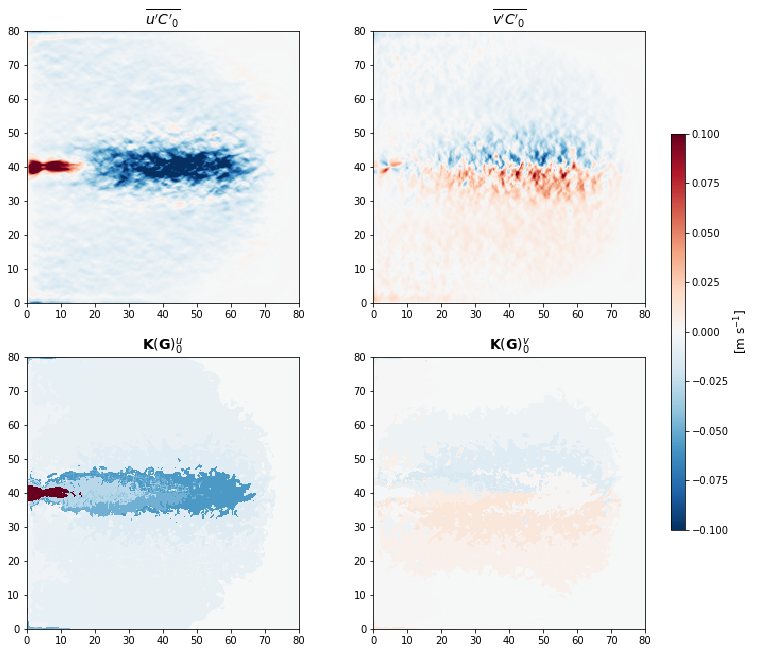

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,11))

im = axes[0,0].pcolormesh(dsp.XC, dsp.YC,
                          dsp.upP0p.isel(time=-int(ntime/2)),
                          vmax=.1, vmin=-.1, cmap='RdBu_r', 
                          shading='auto', rasterized=True)
axes[0,1].pcolormesh(dsp.XC, dsp.YC,
                     dsp.vpP0p.isel(time=-int(ntime/2)),
                     vmax=.1, vmin=-.1, cmap='RdBu_r', 
                     shading='auto', rasterized=True)

for l in clusters:
    
#     p0x_norm = ((P0x.where(dsc.cluster==l) 
#                  - gradPbm1.sel(tracer=0,orient=1,cluster=l)
#                 ) * Ppamp1.sel(tracer=0,cluster=l)**-1
#                ).isel(time=slice(-int(ntime/2),None))                                

#     p0y_norm = ((P0y.where(dsc.cluster==l) 
#                  - gradPbm1.sel(tracer=0,orient=0,cluster=l)
#                 ) * Ppamp1.sel(tracer=0,cluster=l)**-1
#                ).isel(time=slice(-int(ntime/2),None))
    p0x_norm = ((P0xx.where(dsc.cluster==l) 
                 - gradPbm1.sel(tracer=0,orient=1,cluster=l)
                ) * Ppamp1.sel(tracer=0,cluster=l)**-1
               ).isel(time=slice(-int(ntime/2),None))                                

    p0y_norm = ((P0yy.where(dsc.cluster==l) 
                 - gradPbm1.sel(tracer=0,orient=0,cluster=l)
                ) * Ppamp1.sel(tracer=0,cluster=l)**-1
               ).isel(time=slice(-int(ntime/2),None))
    

    vF = xr.ones_like(p0y_norm.isel(time=-int(ntime/2))) * np.nan
    uF = xr.ones_like(p0x_norm.isel(time=-int(ntime/2))) * np.nan
#     X = np.concatenate((X,p1y_norm.isel(time=-int(ntime/2)).data.ravel()[:,np.newaxis]),axis=1)
#     X = np.concatenate((X,p1x_norm.isel(time=-int(ntime/2)).data.ravel()[:,np.newaxis]),axis=1)
#     X = np.concatenate((X,p2y_norm.isel(time=-int(ntime/2)).data.ravel()[:,np.newaxis]),axis=1)
#     X = np.concatenate((X,p2x_norm.isel(time=-int(ntime/2)).data.ravel()[:,np.newaxis]),axis=1)
#     X = np.concatenate((X,p3y_norm.isel(time=-int(ntime/2)).data.ravel()[:,np.newaxis]),axis=1)
#     X = np.concatenate((X,p3x_norm.isel(time=-int(ntime/2)).data.ravel()[:,np.newaxis]),axis=1)
    
    mask = np.ma.masked_invalid(dsc.cluster.where(dsc.cluster==l).isel(time=-int(ntime/2)).data).mask
    
    from joblib import load
    filename = ddir+'MLPRegressors/MLPr-%02dlayers_cluster%02d-%02d_grad2-6yrs.joblib' % (6,l,nGMM)
    mlpr = load(filename)
    
    for j in range(256):
        for i in range(256):
            if mask[j,i] == 0:
                vF[j,i] = mlpr.predict(-np.concatenate((np.array([p0y_norm.isel(time=-int(ntime/2))[j,i]]
                                                                )[:,np.newaxis],
                                                        np.array([p0x_norm.isel(time=-int(ntime/2))[j,i]]
                                                                )[:,np.newaxis]
                                                       ),axis=1))[0][0]
                uF[j,i] = mlpr.predict(-np.concatenate((np.array([p0y_norm.isel(time=-int(ntime/2))[j,i]]
                                                                )[:,np.newaxis],
                                                        np.array([p0x_norm.isel(time=-int(ntime/2))[j,i]]
                                                                )[:,np.newaxis]
                                                       ),axis=1))[0][1]
            else:
                pass
            
    axes[1,1].pcolormesh(dsp.XC, dsp.YC,
                         np.ma.masked_array(vF * Ppamp1.sel(tracer=0,cluster=l).data
                                            + UpPpm1.sel(tracer=0,cluster=l,orient=0).data, mask), 
                         vmax=.1, vmin=-.1, cmap='RdBu_r', 
                         shading='auto', rasterized=True
    )
    axes[1,0].pcolormesh(dsp.XC, dsp.YC,
                         np.ma.masked_array(uF * Ppamp1.sel(tracer=0,cluster=l).data
                                            + UpPpm1.sel(tracer=0,cluster=l,orient=1).data, mask), 
                         vmax=.1, vmin=-.1, cmap='RdBu_r', 
                         shading='auto', rasterized=True
    )
    
axes[0,0].set_title(r"$\overline{u'C'_0}$", fontsize=14)
axes[0,1].set_title(r"$\overline{v'C'_0}$", fontsize=14)
axes[1,0].set_title(r"${\bf K}({\bf G})^u_0$", fontsize=14)
axes[1,1].set_title(r"${\bf K}({\bf G})^v_0$", fontsize=14)
    
axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')
fig.subplots_adjust(right=0.86)
cbaxes = fig.add_axes([0.88, 0.25, 0.016, 0.5]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes,
#                     ticks=[-2.,-1.5,-1.,-.5,0.,.5,1.,1.5,2.]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r"[m s$^{-1}$]", fontsize=12)
plt.savefig(op.join(ddir,'Figs/Ptr0_MLPr-%02dlayers_cluster-%02d_grad2-6yrs_00.pdf' % (6,nGMM)))

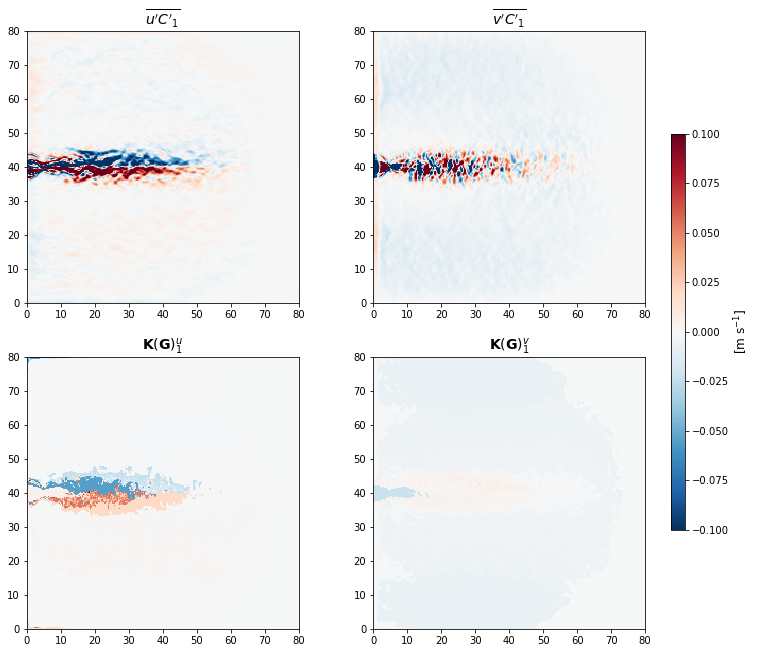

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,11))

im = axes[0,0].pcolormesh(dsp.XC, dsp.YC,
                          dsp.upP1p.isel(time=-int(ntime/2)),
                          vmax=.1, vmin=-.1, cmap='RdBu_r', 
                          shading='auto', rasterized=True)
axes[0,1].pcolormesh(dsp.XC, dsp.YC,
                     dsp.vpP1p.isel(time=-int(ntime/2)),
                     vmax=.1, vmin=-.1, cmap='RdBu_r', 
                     shading='auto', rasterized=True)

for l in clusters:
    
#     p1x_norm = ((P1x.where(dsc.cluster==l) 
#                  - gradPbm1.sel(tracer=1,orient=1,cluster=l)
#                 ) * Ppamp1.sel(tracer=1,cluster=l)**-1
#                ).isel(time=slice(-int(ntime/2),None))                                

#     p1y_norm = ((P1y.where(dsc.cluster==l) 
#                  - gradPbm1.sel(tracer=1,orient=0,cluster=l)
#                 ) * Ppamp1.sel(tracer=1,cluster=l)**-1
#                ).isel(time=slice(-int(ntime/2),None))
    p1x_norm = ((P1xx.where(dsc.cluster==l) 
                 - gradPbm1.sel(tracer=1,orient=1,cluster=l)
                ) * Ppamp1.sel(tracer=1,cluster=l)**-1
               ).isel(time=slice(-int(ntime/2),None))                                

    p1y_norm = ((P1yy.where(dsc.cluster==l) 
                 - gradPbm1.sel(tracer=1,orient=0,cluster=l)
                ) * Ppamp1.sel(tracer=1,cluster=l)**-1
               ).isel(time=slice(-int(ntime/2),None))
    

    vF = xr.ones_like(p1y_norm.isel(time=-int(ntime/2))) * np.nan
    uF = xr.ones_like(p1x_norm.isel(time=-int(ntime/2))) * np.nan
#     X = np.concatenate((X,p1y_norm.isel(time=-int(ntime/2)).data.ravel()[:,np.newaxis]),axis=1)
#     X = np.concatenate((X,p1x_norm.isel(time=-int(ntime/2)).data.ravel()[:,np.newaxis]),axis=1)
#     X = np.concatenate((X,p2y_norm.isel(time=-int(ntime/2)).data.ravel()[:,np.newaxis]),axis=1)
#     X = np.concatenate((X,p2x_norm.isel(time=-int(ntime/2)).data.ravel()[:,np.newaxis]),axis=1)
#     X = np.concatenate((X,p3y_norm.isel(time=-int(ntime/2)).data.ravel()[:,np.newaxis]),axis=1)
#     X = np.concatenate((X,p3x_norm.isel(time=-int(ntime/2)).data.ravel()[:,np.newaxis]),axis=1)
    
    mask = np.ma.masked_invalid(dsc.cluster.where(dsc.cluster==l).isel(time=-int(ntime/2)).data).mask
    
    from joblib import load
    filename = ddir+'MLPRegressors/MLPr-%02dlayers_cluster%02d-%02d_grad2-6yrs.joblib' % (6,l,nGMM)
    mlpr = load(filename)
    
    for j in range(256):
        for i in range(256):
            if mask[j,i] == 0:
                vF[j,i] = mlpr.predict(-np.concatenate((np.array([p1y_norm.isel(time=-int(ntime/2))[j,i]]
                                                                )[:,np.newaxis],
                                                        np.array([p1x_norm.isel(time=-int(ntime/2))[j,i]]
                                                                )[:,np.newaxis]
                                                       ),axis=1))[0][0]
                uF[j,i] = mlpr.predict(-np.concatenate((np.array([p1y_norm.isel(time=-int(ntime/2))[j,i]]
                                                                )[:,np.newaxis],
                                                        np.array([p1x_norm.isel(time=-int(ntime/2))[j,i]]
                                                                )[:,np.newaxis]
                                                       ),axis=1))[0][1]
            else:
                pass
            
    axes[1,1].pcolormesh(dsp.XC, dsp.YC,
                         np.ma.masked_array(vF * Ppamp1.sel(tracer=1,cluster=l).data
                                            + UpPpm1.sel(tracer=1,cluster=l,orient=0).data, mask), 
                         vmax=.1, vmin=-.1, cmap='RdBu_r', 
                         shading='auto', rasterized=True
    )
    axes[1,0].pcolormesh(dsp.XC, dsp.YC,
                         np.ma.masked_array(uF * Ppamp1.sel(tracer=1,cluster=l).data
                                            + UpPpm1.sel(tracer=1,cluster=l,orient=1).data, mask), 
                         vmax=.1, vmin=-.1, cmap='RdBu_r', 
                         shading='auto', rasterized=True
    )
    
axes[0,0].set_title(r"$\overline{u'C'_1}$", fontsize=14)
axes[0,1].set_title(r"$\overline{v'C'_1}$", fontsize=14)
axes[1,0].set_title(r"${\bf K}({\bf G})^u_1$", fontsize=14)
axes[1,1].set_title(r"${\bf K}({\bf G})^v_1$", fontsize=14)
    
axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')
fig.subplots_adjust(right=0.86)
cbaxes = fig.add_axes([0.88, 0.25, 0.016, 0.5]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes,
#                     ticks=[-2.,-1.5,-1.,-.5,0.,.5,1.,1.5,2.]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r"[m s$^{-1}$]", fontsize=12)
plt.savefig(op.join(ddir,'Figs/Ptr1_MLPr-%02dlayers_cluster-%02d_grad2-6yrs_00.pdf' % (6,nGMM)))

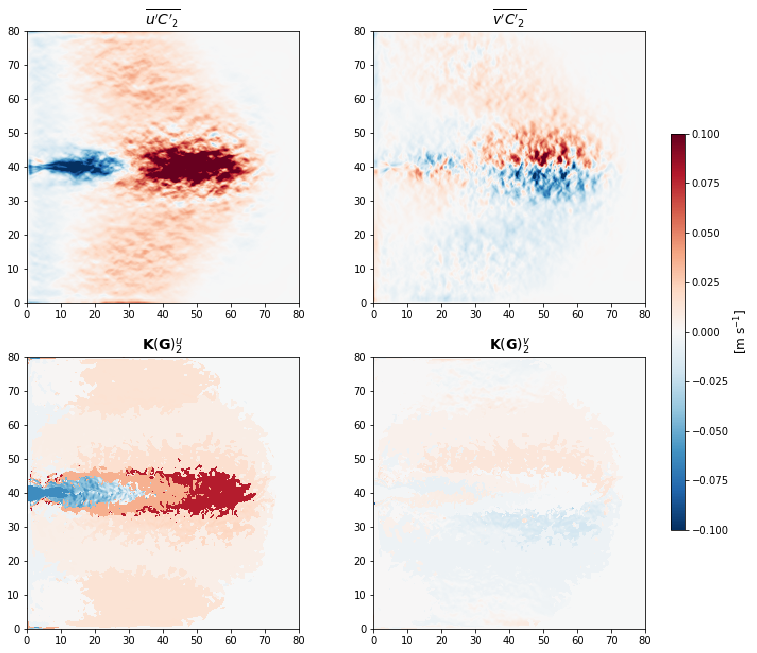

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,11))

im = axes[0,0].pcolormesh(dsp.XC, dsp.YC,
                          dsp.upP2p.isel(time=-int(ntime/2)),
                          vmax=.1, vmin=-.1, cmap='RdBu_r', 
                          shading='auto', rasterized=True)
axes[0,1].pcolormesh(dsp.XC, dsp.YC,
                     dsp.vpP2p.isel(time=-int(ntime/2)),
                     vmax=.1, vmin=-.1, cmap='RdBu_r', 
                     shading='auto', rasterized=True)

for l in clusters:
    
    p2x_norm = ((P2x.where(dsc.cluster==l) 
                 - gradPbm1.sel(tracer=2,orient=1,cluster=l)
                ) * Ppamp1.sel(tracer=2,cluster=l)**-1
               ).isel(time=slice(-int(ntime/2),None))                                

    p2y_norm = ((P2y.where(dsc.cluster==l) 
                 - gradPbm1.sel(tracer=2,orient=0,cluster=l)
                ) * Ppamp1.sel(tracer=2,cluster=l)**-1
               ).isel(time=slice(-int(ntime/2),None))
    

    vF = xr.ones_like(p2y_norm.isel(time=-int(ntime/2))) * np.nan
    uF = xr.ones_like(p2x_norm.isel(time=-int(ntime/2))) * np.nan
#     X = np.concatenate((X,p1y_norm.isel(time=-int(ntime/2)).data.ravel()[:,np.newaxis]),axis=1)
#     X = np.concatenate((X,p1x_norm.isel(time=-int(ntime/2)).data.ravel()[:,np.newaxis]),axis=1)
#     X = np.concatenate((X,p2y_norm.isel(time=-int(ntime/2)).data.ravel()[:,np.newaxis]),axis=1)
#     X = np.concatenate((X,p2x_norm.isel(time=-int(ntime/2)).data.ravel()[:,np.newaxis]),axis=1)
#     X = np.concatenate((X,p3y_norm.isel(time=-int(ntime/2)).data.ravel()[:,np.newaxis]),axis=1)
#     X = np.concatenate((X,p3x_norm.isel(time=-int(ntime/2)).data.ravel()[:,np.newaxis]),axis=1)
    
    mask = np.ma.masked_invalid(dsc.cluster.where(dsc.cluster==l).isel(time=-int(ntime/2)).data).mask
    
    from joblib import load
    filename = ddir+'MLPRegressors/MLPr-%02dlayers_cluster%02d-%02d_grad2-6yrs.joblib' % (6,l,nGMM)
    mlpr = load(filename)
    
    for j in range(256):
        for i in range(256):
            if mask[j,i] == 0:
                vF[j,i] = mlpr.predict(-np.concatenate((np.array([p2y_norm.isel(time=-int(ntime/2))[j,i]]
                                                                )[:,np.newaxis],
                                                        np.array([p2x_norm.isel(time=-int(ntime/2))[j,i]]
                                                                )[:,np.newaxis]
                                                       ),axis=1))[0][0]
                uF[j,i] = mlpr.predict(-np.concatenate((np.array([p2y_norm.isel(time=-int(ntime/2))[j,i]]
                                                                )[:,np.newaxis],
                                                        np.array([p2x_norm.isel(time=-int(ntime/2))[j,i]]
                                                                )[:,np.newaxis]
                                                       ),axis=1))[0][1]
            else:
                pass
            
    axes[1,1].pcolormesh(dsp.XC, dsp.YC,
                         np.ma.masked_array(vF * Ppamp1.sel(tracer=2,cluster=l).data
                                            + UpPpm1.sel(tracer=2,cluster=l,orient=0).data, mask), 
                         vmax=.1, vmin=-.1, cmap='RdBu_r', 
                         shading='auto', rasterized=True
    )
    axes[1,0].pcolormesh(dsp.XC, dsp.YC,
                         np.ma.masked_array(uF * Ppamp1.sel(tracer=2,cluster=l).data
                                            + UpPpm1.sel(tracer=2,cluster=l,orient=1).data, mask), 
                         vmax=.1, vmin=-.1, cmap='RdBu_r', 
                         shading='auto', rasterized=True
    )
    
axes[0,0].set_title(r"$\overline{u'C'_2}$", fontsize=14)
axes[0,1].set_title(r"$\overline{v'C'_2}$", fontsize=14)
axes[1,0].set_title(r"${\bf K}({\bf G})^u_2$", fontsize=14)
axes[1,1].set_title(r"${\bf K}({\bf G})^v_2$", fontsize=14)
    
axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')
fig.subplots_adjust(right=0.86)
cbaxes = fig.add_axes([0.88, 0.25, 0.016, 0.5]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes,
#                     ticks=[-2.,-1.5,-1.,-.5,0.,.5,1.,1.5,2.]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r"[m s$^{-1}$]", fontsize=12)
plt.savefig(op.join(ddir,'Figs/Ptr2_MLPr-%02dlayers_cluster-%02d_grad2-6yrs_00.pdf' % (6,nGMM)))